In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Let us see the classes present in the dataset:

In [ ]:
# USAGE Comment this out if running code locally
from google.colab import drive
drive.mount('/content/drive')

# USAGE Change directory here according to where data is 
data_dir  = '/content/drive/My Drive/ML/HooHacksData/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']


## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)
#print(type(dataset))

Let's create a helper function to see the image and its corresponding label:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


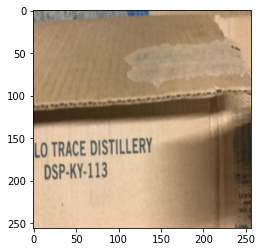

In [ ]:
img, label = dataset[12]
show_sample(img, label)

# Loading and Splitting Data:

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [ ]:
#print(len(dataset))
train_ds, val_ds, test_ds = random_split(dataset, [1593-12, 176-11, 758-11])
len(train_ds), len(val_ds), len(test_ds)

(1581, 165, 747)

In [ ]:
from torch.utils.data.dataloader import DataLoader
import numpy as np
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


This is a helper function to visualize batches:

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


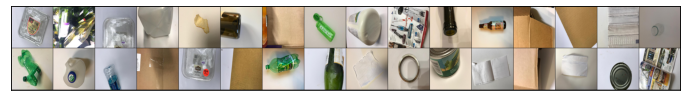

In [ ]:
show_batch(train_dl)

# Model Base:

Let's create the model base:

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet50 for classifying images:

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

This is the function for fitting the model.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.23831643164157867, 'val_loss': 1.7886537313461304}

Let's start training the model:

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 1.4642, val_loss: 1.2349, val_acc: 0.8806
Epoch 2: train_loss: 1.1833, val_loss: 1.1485, val_acc: 0.9195
Epoch 3: train_loss: 1.0967, val_loss: 1.1103, val_acc: 0.9792
Epoch 4: train_loss: 1.0701, val_loss: 1.1064, val_acc: 0.9531
Epoch 5: train_loss: 1.0618, val_loss: 1.1184, val_acc: 0.9441
Epoch 6: train_loss: 1.0584, val_loss: 1.1147, val_acc: 0.9531
Epoch 7: train_loss: 1.0571, val_loss: 1.1136, val_acc: 0.9233
Epoch 8: train_loss: 1.0574, val_loss: 1.1238, val_acc: 0.9479


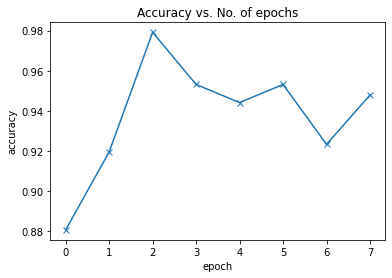

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

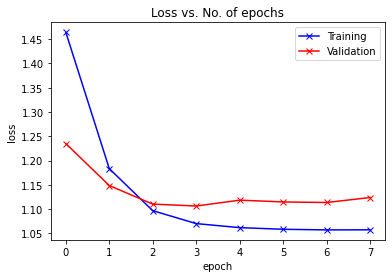

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [ ]:
def predict_image(img):
    #img.reshape((3, 256, 256))
    
    #print(torch.from_numpy(img))
    #img = torch.from_numpy(img).reshape(3, 256, 256).float()
    print(img)
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    array = yb.cpu().detach().numpy()
    array = np.append([classes], array, axis = 0)
    #return array.flatten()
    print(str(dataset.classes[preds[0].item()]))
    return str(dataset.classes[preds[0].item()])

def predict_image2(img):
    '''torchvision.transforms.ToPILImage( mode=None )
    img2 = transforms.ToPILImage(img)
    transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    img2 = transformations(img2)'''
    #img = transform(img, transformations)    
    #print(torch.from_numpy(img))
    img = torch.from_numpy(img).reshape(3, 256, 256).long()/256
    print(img)
    print(img.shape)
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    array = yb.cpu().detach().numpy()
    array = np.append([classes], array, axis = 0)
    #return array.flatten()
    #print(str(dataset.classes[preds[0].item()]))
    return str(dataset.classes[preds[0].item()])


Let us see the model's predictions on the test dataset:

torch.Size([3, 256, 256])
tensor([[[0.9216, 0.9216, 0.9216,  ..., 0.7020, 0.6980, 0.6941],
         [0.9216, 0.9216, 0.9216,  ..., 0.6980, 0.6941, 0.6941],
         [0.9216, 0.9216, 0.9216,  ..., 0.6980, 0.6941, 0.6902],
         ...,
         [0.9255, 0.9255, 0.9216,  ..., 0.6980, 0.6980, 0.6980],
         [0.9255, 0.9294, 0.9255,  ..., 0.6941, 0.6941, 0.6941],
         [0.9294, 0.9294, 0.9255,  ..., 0.6902, 0.6902, 0.6902]],

        [[0.9294, 0.9294, 0.9294,  ..., 0.7020, 0.6980, 0.6941],
         [0.9294, 0.9294, 0.9294,  ..., 0.6980, 0.6941, 0.6941],
         [0.9294, 0.9294, 0.9294,  ..., 0.6980, 0.6941, 0.6902],
         ...,
         [0.9333, 0.9333, 0.9294,  ..., 0.6980, 0.6980, 0.6980],
         [0.9333, 0.9373, 0.9333,  ..., 0.6941, 0.6941, 0.6941],
         [0.9373, 0.9373, 0.9333,  ..., 0.6902, 0.6902, 0.6902]],

        [[0.9804, 0.9804, 0.9804,  ..., 0.7490, 0.7451, 0.7412],
         [0.9804, 0.9804, 0.9804,  ..., 0.7451, 0.7412, 0.7412],
         [0.9804, 0.9804, 0.9804

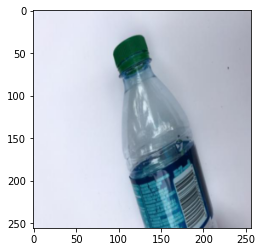

In [ ]:
img, label = test_ds[17]
print(test_ds[17][0].shape)
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', str(predict_image(img)))

torch.Size([3, 256, 256])
paper
Label: paper , Predicted: paper


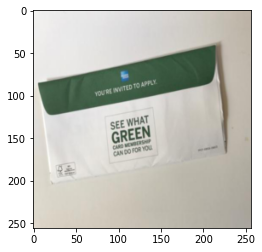

In [ ]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img))

In [ ]:
loaded_model = model
torch.save(loaded_model, "model.pt")



Install gradio with pip

In [ ]:
!pip install -q gradio

     |████████████████████████████████| 668 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 38.7 MB/s 
     |████████████████████████████████| 255 kB 23.1 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 2.0 MB 45.3 MB/s 
     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 211 kB 72.9 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 35.0 MB/s 
     |████████████████████████████████| 144 kB 62.6 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 10.9 MB 55.9 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 61 kB 389 kB/s 
     |████████████████████████████████| 3.6 MB 47.3 MB/s 
     |████████████████████████

Run the gradio GUI

In [ ]:
#hide_output
import requests
import tensorflow as tf    

import gradio as gr      #Make sure to run the pip install for gradio above!

image = gr.inputs.Image(shape=(256, 256))
#label = gr.outputs.Label(num_top_classes=3, type = "auto")
label = gr.outputs.Textbox()


gr.Interface(
    fn=predict_image2,  
    inputs=image,
    outputs="text",
    layout="vertical",
    theme="dark-peach",
    title= "Garbage Identifier",
    description= "<center>Developed by Alexi Gladstone and Zach Russell",
    article= "If our guess was wrong, let us know by pressing the Flag button!",  #Sorry this doesn't work yet!
).launch(debug = True) #Keep this to true if you want to debug any errors


NameError: ignored